In [6]:
import numpy as np
from scipy.stats import multivariate_normal

In [7]:
class JednostavniGMM:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
        """
        Inicijalizacija parametara modela.
        :param n_clusters: Broj klastera (K) - npr. 3 (pozadina, objekt, defekt)
        :param max_iter: Maksimalan broj ponavljanja EM algoritma
        :param tol: Tolerancija (ako se log-likelihood malo mijenja, stajemo)
        """
        self.k = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        
        self.means = None       # Centri (boje)
        self.covs = None        # Matrice kovarijanse 
        self.weights = None     # Težine/Pi (učestalost klastera)

    def fit(self, X):
        """
        Trenira model na podacima X.
        """
        n_samples, n_features = X.shape 
        
        # Nasumično odabrati k piksela da budu početni centri
        random_indices = np.random.choice(n_samples, self.k, replace=False)
        self.means = X[random_indices]
        
        # Inicijalizujemo kovarijanse kao dijagonalne matrice
        self.covs = [np.eye(n_features) * 10 for _ in range(self.k)]
        
        # Težine su iste za sve (1/K)
        self.weights = np.full(self.k, 1 / self.k)
        
        log_likelihoods = [] # Za praćenje napretka

        # EM algoritam
        for i in range(self.max_iter):
            
            # Expectation
            # Brojnik iz formule (Težina * Gaussova_Vjerovatnoća)
            weighted_probs = np.zeros((n_samples, self.k))
            
            for j in range(self.k):
                # Scipy za Gaussovu formulu
                distribucija = multivariate_normal(mean=self.means[j], 
                                                   cov=self.covs[j], 
                                                   allow_singular=True)
                # Brojnik: Pi_k * N(x | Mu_k, Sigma_k)
                weighted_probs[:, j] = self.weights[j] * distribucija.pdf(X)
            
            # Nazivnik: Ukupna vjerovatnoća piksela (suma po redovima)
            sum_probs = weighted_probs.sum(axis=1)[:, np.newaxis]
            
            # Log-Likelihood (za provjeru konvergencije)
            log_likelihood = np.sum(np.log(sum_probs + 1e-10)) # 1e-10 da ne logaritmujemo nulu
            log_likelihoods.append(log_likelihood)
            
            # Responsibility (Gamma): Brojnik / Nazivnik
            # Ovo su procenti pripadnosti
            responsibilities = weighted_probs / (sum_probs + 1e-10)

            # Maximization
            # Nk: Efektivni broj piksela u svakom klasteru (suma odgovornosti)
            N_k = responsibilities.sum(axis=0)
            
            for j in range(self.k):
                # Nova Srednja vrijednost (Mu) - Težinski prosjek
                # Suma(odgovornost * vrijednost_piksela) / Nk
                self.means[j] = (responsibilities[:, j] @ X) / N_k[j]
                
                # Nova Kovarijansa (Sigma)
                # Suma(odgovornost * (x-mu)*(x-mu)^T) / Nk
                diff = X - self.means[j] # Razlika piksela od centra
                
                # Množenje matrica
                self.covs[j] = (responsibilities[:, j] * diff.T @ diff) / N_k[j]
                
                # ako se klaster skupi u jednu tačku (da determinanta ne bude 0)
                self.covs[j] += np.eye(n_features) * 1e-6
                
                # Nove Težine (Pi)
                self.weights[j] = N_k[j] / n_samples

            # Provjera konvergencije
            if i > 0 and abs(log_likelihood - log_likelihoods[-2]) < self.tol:
                break
                
    def predict(self, X):
        """
        Vraća konačnu klasu za svaki piksel.
        """
        weighted_probs = np.zeros((X.shape[0], self.k))
        for j in range(self.k):
            dist = multivariate_normal(mean=self.means[j], 
                                       cov=self.covs[j], 
                                       allow_singular=True)
            weighted_probs[:, j] = self.weights[j] * dist.pdf(X)
            
        # Vrati indeks kolone sa najvećom vjerovatnoćom 
        return np.argmax(weighted_probs, axis=1)

In [8]:
import cv2
import matplotlib.pyplot as plt

def segmentiraj_sliku(putanja_do_slike, broj_klastera=3):
    """
    Učitava sliku, pokreće GMM i prikazuje rezultat.
    """
    print(f"--- Obrada slike: {putanja_do_slike} sa {broj_klastera} klastera ---")
    
    # 1. Učitavanje slike
    img = cv2.imread(putanja_do_slike)
    if img is None:
        print("Greška: Slika nije pronađena!")
        return
    
    # Prebacivanje iz BGR u RGB 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    original_shape = img.shape
    
    # Priprema podataka 
    # Pretvoriti matricu (H, W, 3) u listu (H*W, 3)
    pixels = img.reshape(-1, 3)
    pixels = np.float32(pixels) # Pretvoriti u float radi preciznosti
    
    # Kreiranje i treniranje GMM-a
    gmm = JednostavniGMM(n_clusters=broj_klastera, max_iter=30)
    gmm.fit(pixels) 
    
    # Dobijanje rezultata (Segmentacija)
    labels = gmm.predict(pixels) # Svaki piksel dobija oznaku
    
    # 5. Rekonstrukcija slike za prikaz
    # Umjesto originalnih boja, svakom pikselu dajemo boju centra njegovog klastera.
    segmented_data = gmm.means[labels] 
    segmented_img = segmented_data.reshape(original_shape).astype(np.uint8)
    
    # 6. Vizuelizacija
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Originalna slika")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(segmented_img)
    plt.title(f"GMM Segmentacija (K={broj_klastera})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


--- Obrada slike: images/MetalNut_good.png sa 2 klastera ---


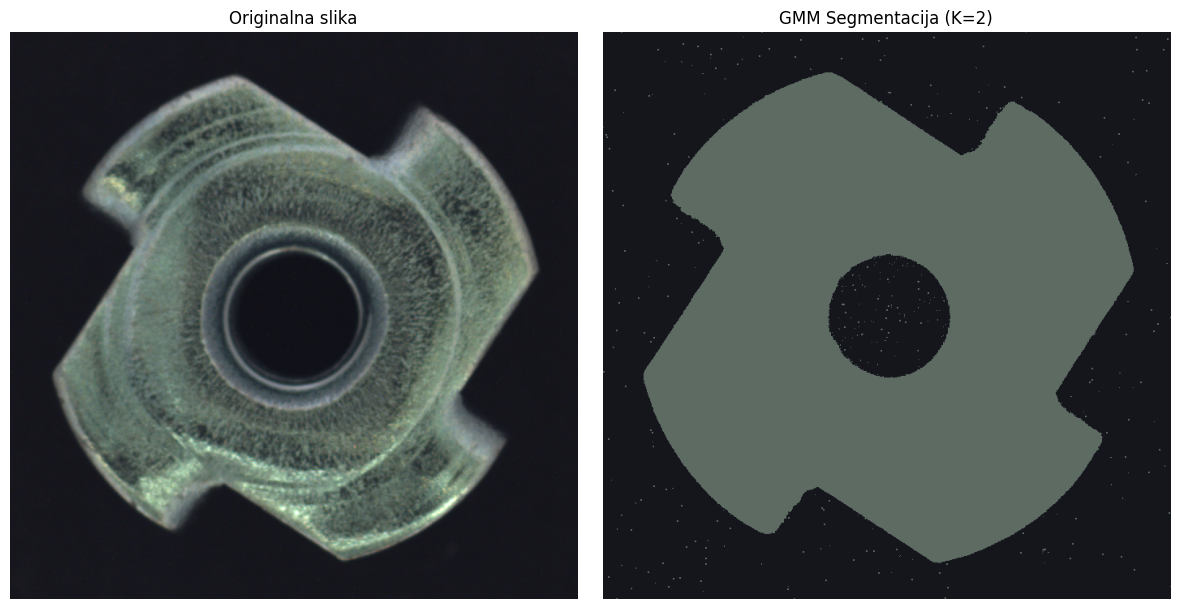

--- Obrada slike: images/Hazelnut_good.png sa 2 klastera ---


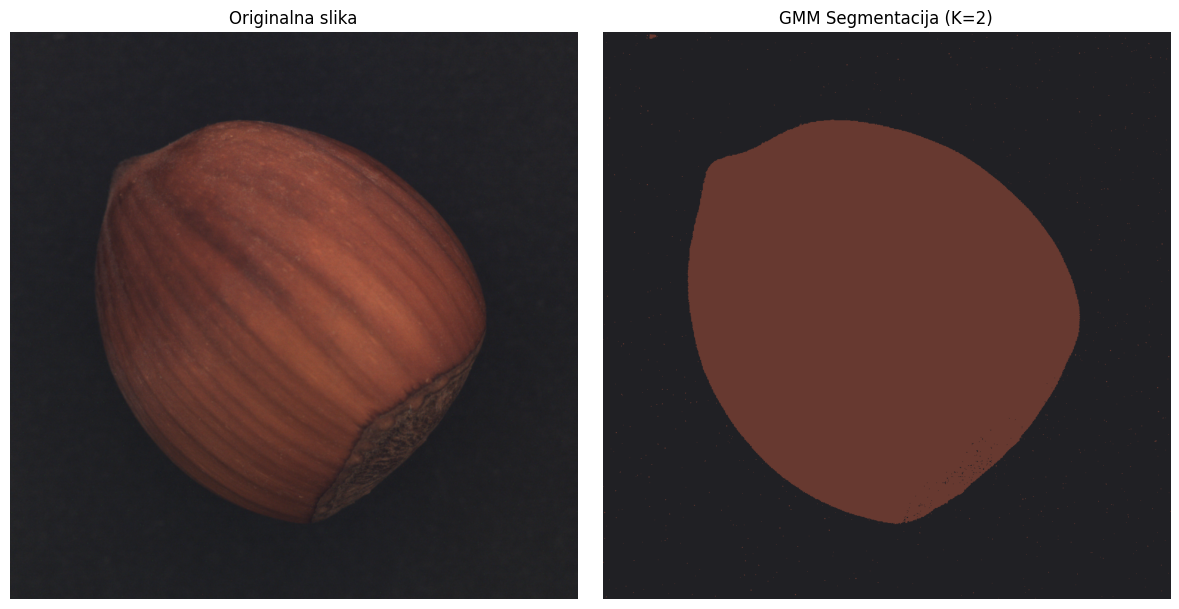

--- Obrada slike: images/Capsule_good.png sa 2 klastera ---


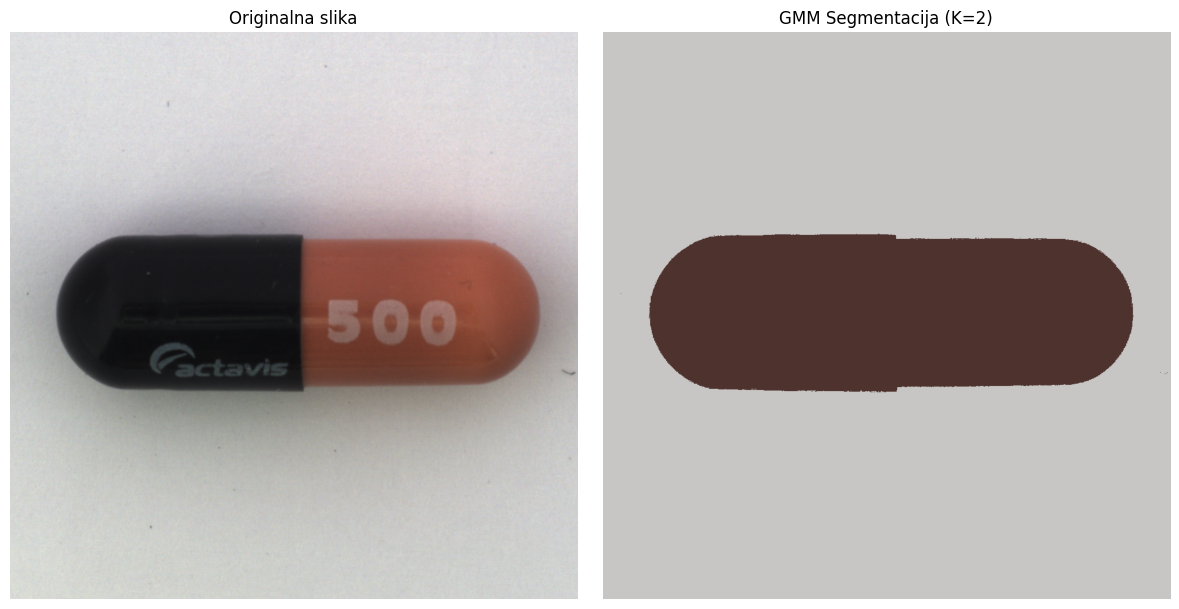

In [11]:
segmentiraj_sliku("images/MetalNut_good.png", 2);
segmentiraj_sliku("images/Hazelnut_good.png", 2);
segmentiraj_sliku("images/Capsule_good.png", 2);